In [4]:
from time import perf_counter as clock
from os import path
import glob 
import numpy as np
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import scipy.ndimage

In [5]:
specfile = '/Users/kamiori/Desktop/Python/Research Project/OH Megamesa/line_fitting/edit-cap0-iras11-239-p15.fits'
print(specfile)


/Users/kamiori/Desktop/Python/Research Project/OH Megamesa/line_fitting/edit-cap0-iras11-239-p15.fits


In [6]:
file = str(specfile) # makes sure the filename is a string, this is recquired for fits.open to read them. 
hdu = fits.open(file)
gal_lin = hdu[0].data # loads the actual image/spectrum data
h1 = hdu[0].header
z = 0.01078
FWHM_gal = 3.838
lamRange = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])  
print(h1)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    1 / Number of axes                                 NAXIS1  =                 3132 / Axis length                                    EXTEND  =                    F / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        OBJECT  = 'IRAS11506-3851'     / Name of the object observed                    DATE    = '2019-05-22T20:01:08' / Date FITS file was generated                  IRAF-TLM= '2019-05-22T20:01:08' / Time of last modification                     CTYPE1  = 'LINEAR  '           / R.A. in tangent plane projection               CRPIX1  =                   1. / Ref pix of axis 1                              CRVAL1  =     4184.45458984375 / RA at Ref pix in decimal degrees               CD1_1   =     1.00779128074646 / WCS mat

Log re-bin the data:

In [7]:
galaxy1, logLam1, velscale = util.log_rebin(lamRange, gal_lin) # logrithmic rebin of the flux and wavelength
galaxy = galaxy1/np.median(galaxy1)  # Normalize spectrum to avoid numerical issues
lam = np.exp(logLam1) # obtain array of linear wavelengths
wave = lam
mask_between = [(5188, 5245), (6267,6325), (6859, 6928), (5960, 5997), (5571, 5582), (4397, 4417), (5881,5901)]

for i in mask_between:
        lam = np.ma.masked_inside(lam, i[0], i[1])
    
mask = ~np.ma.getmask(lam) # get the inverted mask
    
    # using randomly selected noise
    # Could potentially make this the noise spectrum rather than constant noise
noise = np.full_like(galaxy, 0.0456)
    
    # min/max of wavelength 
lam_range_gal = np.array([np.min(wave), np.max(wave)])/(z+1)

Setup templates

In [8]:
 ## RW - didn't change this section much from SDSS example. 
miles_dir = '/Users/kamiori/Desktop/Python/env/lib/python3.10/site-packages/ppxf/miles_models/'    
pathname = str(miles_dir) + 'Eun1.30*.fits' 
miles = lib.miles(pathname, velscale, FWHM_gal)

    # The stellar templates are reshaped into a 2-dim array with each spectrum
    # as a column, however we save the original array dimensions, which are
    # needed to specify the regularization dimensions
reg_dim = miles.templates.shape[1:]
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
regul_err = 0.013  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
#            lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1 + z) # I put this in earlier in the code under Galaxy Wavelength Range
gas_templates, gas_names, line_wave = \
        util.emission_lines(miles.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer = False)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #
templates = np.column_stack([stars_templates, gas_templates])

Emission lines included in gas templates:
['Hgamma' 'Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']


In [9]:
c = 299792.458
#            dv = 4455
dv = c*(miles.ln_lam_temp[0] - np.log(wave[0])) # km/s
    
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

Emission Lines

In [10]:
n_temps = stars_templates.shape[1]
    ### RW - the following need to be changed based on how many emission lines are present, such as whether hbeta is detected or not
n_balmer = 3  # Number of Balmer lines included in the fit
n_forbidden = 5 
n_lines = 6
    #n_forbidden = 7 #[OII] lines included

#            n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]" 
#            n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    
#            component = [0]*n_temps + [1]*n_lines
component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
print(len(component))
gas_component = np.array(component) > 0
    
moments = [4, 2, 2]

    # Adopt the same starting value for the stars and the two gas components
start = [start, start, start]
    
t = clock()
reddening = 0.780

158


In [11]:
pp = ppxf(templates, galaxy, noise, velscale, start,
              moments=moments, degree=4, vsyst=dv, lam=wave,
              regul=1./regul_err, reg_dim=reg_dim, component=component,
              gas_component=gas_component, gas_names=gas_names, mask = mask, reddening = reddening)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      2877       148    -0.058    -0.300
 comp.  1:      2866       103
 comp.  2:      2873       101
Stars Reddening E(B-V): 1.077
chi2/DOF: 2.820; DOF: 2864; degree = 4; mdegree = 0
method = capfit; Jac calls: 13; Func calls: 138; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 75/158
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Hgamma      2.657      0.15    2866   103
Comp:  1                 Hbeta      4.822      0.14    2866   103
Comp:  1                Halpha      27.05      0.13    2866   103
Comp:  2             [SII]6716      4.105      0.13    2873   101
Comp:  2             [SII]6731      3.343      0.13    2873   101
Comp:  2          [OIII]5007_d      1.601      0.18    2873   101
Comp:  2            [OI]6300_d      2.590 

Desired Delta Chi^2: 79.15
Current Delta Chi^2: 5700
Elapsed time in PPXF: 10.88 s
Weighted <lg_age> [yr]: 9.73
Weighted <[M/H]>: -0.231
(M*/L)_r: 1.482


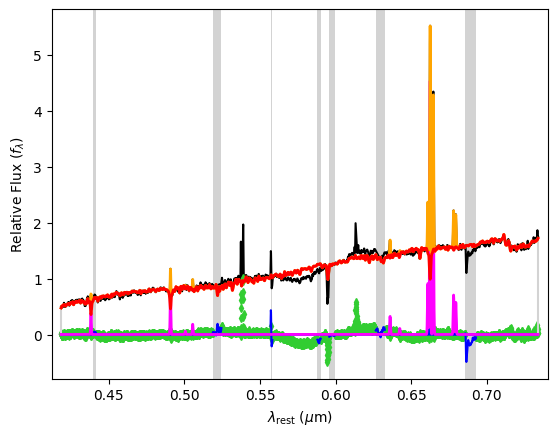

In [12]:
print('Desired Delta Chi^2: %.4g' % np.sqrt(2*galaxy.size))
print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*galaxy.size))
print('Elapsed time in PPXF: %.2f s' % (clock() - t))

weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

miles.mean_age_metal(weights)
miles.mass_to_light(weights, band="r")
plt.figure()

    # Plot fit results for stars and gas.
plt.clf()
pp.plot()

In [13]:
# extract fitted spectra
output_direct = '/Users/kamiori/Desktop/Python/line_fitting/fit_data/'
wlen = pp.lam  #wavelength
gal_spectrum = pp.galaxy   #spectrum (input data)
specfit = pp.bestfit  # best fit spectrum
gas = pp.gas_component # number of gas components
spectra = pp.matrix[:, pp.degree + 1 :]
gas_spectrum = spectra[:, gas].dot(pp.weights[gas]) #emiision line spectrum
stars_spectrum = specfit - gas_spectrum 
newgal_spectrum = gal_spectrum - stars_spectrum # subtract fit to stellar component from original spectrum
Nwlen = np.size(wlen)
    
out_direc = output_direct
if not os.path.isdir(out_direc):
    os.makedirs(out_direc)

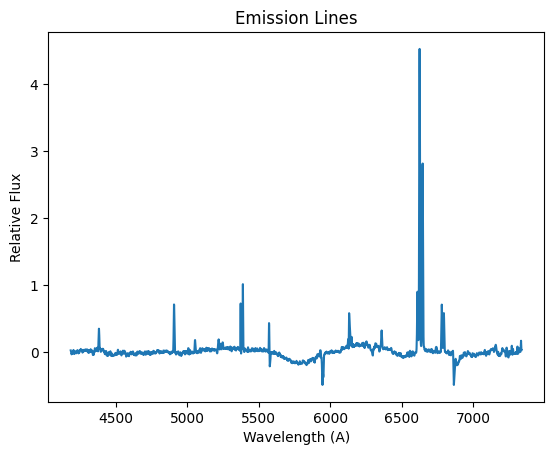

In [14]:
plt.plot(wlen, newgal_spectrum)
plt.xlabel('Wavelength (A)')
plt.ylabel('Relative Flux')
plt.title('Emission Lines')
plt.show()
